# Churn Telco
---

# Análisis de Churn de Clientes en Telecomunicaciones
## Framework Completo de Análisis

---

## **Abstract**

El churn de clientes representa uno de los mayores desafíos para las empresas de telecomunicaciones, con costos de adquisición de nuevos clientes que superan 5-25 veces el costo de retener clientes existentes. Este análisis desarrollará un sistema predictivo de propensión al churn utilizando técnicas de machine learning sobre datos transaccionales y demográficos de clientes.

*Objetivo*
* Construccion de un ML de clasificacion binaria
* Objetivizar la propensión a la conversión
* Validar cuales son las caracteristicas mas influyentes en este modelo

**Metodología**: Análisis exploratorio de datos, ingeniería de features, modelado predictivo con algoritmos de clasificación, y validación del modelo mediante métricas de negocio.

**Impacto Esperado**: Reducción del 15-25% en la tasa de churn mediante identificación temprana y estrategias de retención dirigidas.

---

## **Hipótesis de Análisis**

### **H1: Hipótesis de Lealtad Temporal**
- **Hipótesis**: Los clientes con mayor tenure (antigüedad) tienen menor propensión al churn
- **Justificación**: La inversión de tiempo y la familiaridad con el servicio crean barreras de salida
- **Test**: Correlación negativa entre tenure y churn rate

### **H2: Hipótesis de Compromiso Contractual**
- **Hipótesis**: Los contratos de largo plazo (2 años) reducen significativamente el churn vs. month-to-month
- **Justificación**: Los contratos largos implican penalizaciones por cancelación anticipada
- **Test**: Comparación de churn rates por tipo de contrato

### **H3: Hipótesis de Valor Percibido**
- **Hipótesis**: Existe una relación U-invertida entre MonthlyCharges y churn (churn alto en extremos de precio)
- **Justificación**: Clientes con precios muy bajos pueden tener servicios limitados; precios muy altos generan sensibilidad al costo
- **Test**: Análisis de churn rate por quintiles de precio

### **H4: Hipótesis de Servicios Adicionales**
- **Hipótesis**: Los clientes con servicios de valor agregado (OnlineSecurity, TechSupport) tienen menor churn
- **Justificación**: Más servicios incrementan el switching cost y la dependencia
- **Test**: Churn rate por número de servicios adicionales contratados

### **H5: Hipótesis Demográfica**
- **Hipótesis**: Los adultos mayores sin dependientes tienen mayor propensión al churn
- **Justificación**: Menor tolerancia a la tecnología y menos necesidades de conectividad familiar
- **Test**: Segmentación por SeniorCitizen + Dependents

### **H6: Hipótesis de Método de Pago**
- **Hipótesis**: Los métodos de pago automáticos reducen el churn vs. pagos manuales
- **Justificación**: Mayor fricción en pagos manuales puede generar insatisfacción
- **Test**: Churn rate por PaymentMethod

---

In [387]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# setting display
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [388]:
def pandas_sqlite_read(db_path, query, params=None):
    with sqlite3.connect(db_path) as conn:
        # Leer directamente a DataFrame
        if params:
            df = pd.read_sql_query(query, conn, params=params)
        else:
            df = pd.read_sql_query(query, conn)
    
    return df

In [389]:
class ChurnDatabase:
    
    def __init__(self, db_path):
        self.db_path = db_path
        
    def get_all_customers(self):
        query = "SELECT * FROM telco_customer_churn"
        return pandas_sqlite_read(self.db_path, query)
    
    def get_churn_customers(self):
        query = "SELECT * FROM telco_customer_churn WHERE Churn = 'Yes'"
        return pandas_sqlite_read(self.db_path, query)
    
    def get_customers_by_contract(self, contract_type):
        query = "SELECT * FROM telco_customer_churn WHERE Contract = ?"
        return pandas_sqlite_read(self.db_path, query, params=[contract_type])
    
    def get_high_value_customers(self, min_charges):
        query = """
        SELECT customerID, gender, tenure, Contract, 
               MonthlyCharges, TotalCharges, Churn
        FROM telco_customer_churn
        WHERE TotalCharges > ?
        ORDER BY TotalCharges DESC
        """
        return pandas_sqlite_read(self.db_path, query, params=[min_charges])
    
    def get_churn_analysis_data(self):
        
        query = """
        SELECT 
            gender,
            SeniorCitizen,
            Partner,
            Dependents,
            tenure,
            PhoneService,
            MultipleLines,
            InternetService,
            OnlineSecurity,
            OnlineBackup,
            DeviceProtection,
            TechSupport,
            StreamingTV,
            StreamingMovies,
            Contract,
            PaperlessBilling,
            PaymentMethod,
            MonthlyCharges,
            TotalCharges,
            Churn,
            -- Features derivadas
            CASE 
                WHEN tenure <= 12 THEN 'New'
                WHEN tenure <= 36 THEN 'Regular' 
                ELSE 'Loyal'
            END as customer_segment,
            
            CASE 
                WHEN MonthlyCharges < 35 THEN 'Low'
                WHEN MonthlyCharges < 65 THEN 'Medium'
                ELSE 'High'
            END as price_segment,
            
            -- Número de servicios adicionales
            (CASE WHEN OnlineSecurity = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN OnlineBackup = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN DeviceProtection = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN TechSupport = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN StreamingTV = 'Yes' THEN 1 ELSE 0 END +
             CASE WHEN StreamingMovies = 'Yes' THEN 1 ELSE 0 END) as additional_services
             
        FROM telco_customer_churn
        """
        return pandas_sqlite_read(self.db_path, query)
    
    def get_churn_summary_stats(self):

        query = """
        SELECT 
            Contract,
            PaymentMethod,
            COUNT(*) as total_customers,
            SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as churn_customers,
            ROUND(
                100.0 * SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(*), 
                2
            ) as churn_rate,
            ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charges,
            ROUND(AVG(tenure), 2) as avg_tenure
        FROM telco_customer_churn
        GROUP BY Contract, PaymentMethod
        ORDER BY churn_rate DESC
        """
        return pandas_sqlite_read(self.db_path, query)
    
    def get_dataframe_by_query(self, query:str):
        return pandas_sqlite_read(self.db_path, query)

In [390]:
churn = ChurnDatabase("../database/telco_customer_churn.sqlite.db")

In [391]:
churn_summary = churn.get_churn_summary_stats()

In [392]:
churn_summary

,Contract,PaymentMethod,total_customers,churn_customers,churn_rate,avg_monthly_charges,avg_tenure
0,Month-to-month,Electronic check,1850,994,53.73,74.99,17.97
1,Month-to-month,Bank transfer (automatic),589,201,34.13,69.09,24.90
2,Month-to-month,Credit card (automatic),543,178,32.78,67.68,23.96
3,Month-to-month,Mailed check,893,282,31.58,46.05,10.04
4,One year,Electronic check,347,64,18.44,79.10,46.18
5,One year,Credit card (automatic),398,41,10.30,67.97,45.48
6,One year,Bank transfer (automatic),391,38,9.72,67.48,46.02
7,Two year,Electronic check,168,13,7.74,84.34,61.11
8,One year,Mailed check,337,23,6.82,44.31,29.12
9,Two year,Bank transfer (automatic),564,19,3.37,65.01,61.60


In [393]:
def create_churn_heatmap(df):
    """Heatmap mostrando churn rate por Contract vs PaymentMethod"""
    
    # Crear pivot table
    pivot_data = df.pivot(index='Contract', columns='PaymentMethod', values='churn_rate')
    
    plt.figure(figsize=(16, 9))
    
    # Crear heatmap
    sns.heatmap(pivot_data, 
                annot=True, 
                cmap='Reds', 
                fmt='.1f',
                cbar_kws={'label': 'Churn Rate (%)'},
                linewidths=0.5)
    
    plt.title('CHURN RATE HEATMAP\nContract Type vs Payment Method', 
              fontsize=16, fontweight='bold', pad=20)
    
    plt.xlabel('Payment Method', fontsize=12, fontweight='bold')
    plt.ylabel('Contract Type', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Añadir insights como texto
    # plt.figtext(0.02, 0.02, 
    #             "Key Insight: Month-to-month + Electronic check = Highest churn (53.7%)\n"
    #             "Best retention: Two year + Mailed check (0.8% churn)", 
    #             fontsize=10, style='italic', 
    #             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.show()


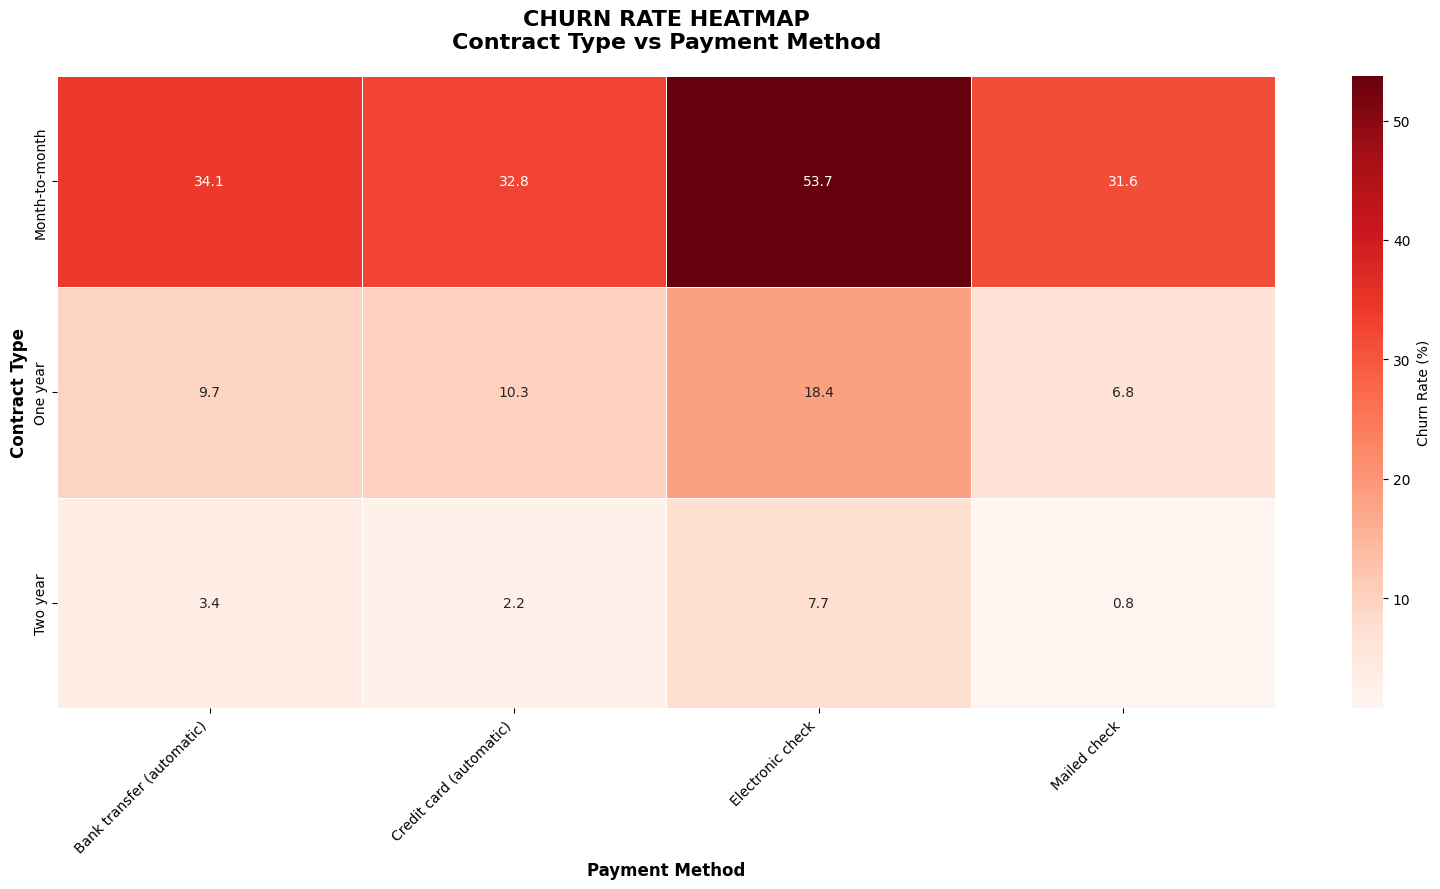

In [394]:
create_churn_heatmap(churn_summary)

In [395]:
def create_bubble_chart(df):
    """Bubble chart: Churn Rate vs Monthly Charges, size = Customer Volume"""
    
    plt.figure(figsize=(16, 9))
    
    # Crear colores por tipo de contrato
    colors = {'Month-to-month': '#FF6B6B', 'One year': '#4ECDC4', 'Two year': '#45B7D1'}
    
    for contract in df['Contract'].unique():
        contract_data = df[df['Contract'] == contract]
        
        plt.scatter(contract_data['avg_monthly_charges'], 
                   contract_data['churn_rate'],
                   s=contract_data['total_customers'] / 5,  # Tamaño proporcional
                   alpha=0.7,
                   c=colors[contract],
                   label=contract,
                   edgecolors='black',
                   linewidth=1)
        
        # Añadir etiquetas para puntos críticos
        for idx, row in contract_data.iterrows():
            if row['churn_rate'] > 30 or row['churn_rate'] < 5:
                plt.annotate(f"{row['PaymentMethod']}\n({row['churn_rate']:.1f}%)", 
                           (row['avg_monthly_charges'], row['churn_rate']),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, ha='left')
    
    plt.xlabel('Average Monthly Charges ($)', fontsize=12, fontweight='bold')
    plt.ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
    plt.title('CHURN vs PRICING ANALYSIS\n(Bubble size = Customer Volume)', 
              fontsize=16, fontweight='bold', pad=20)
              
    plt.legend(title='Contract Type', title_fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Añadir líneas de referencia
    plt.axhline(y=df['churn_rate'].mean(), color='red', linestyle='--', alpha=0.5, 
                label=f'Avg Churn ({df["churn_rate"].mean():.1f}%)')
    
    plt.tight_layout()
    plt.show()


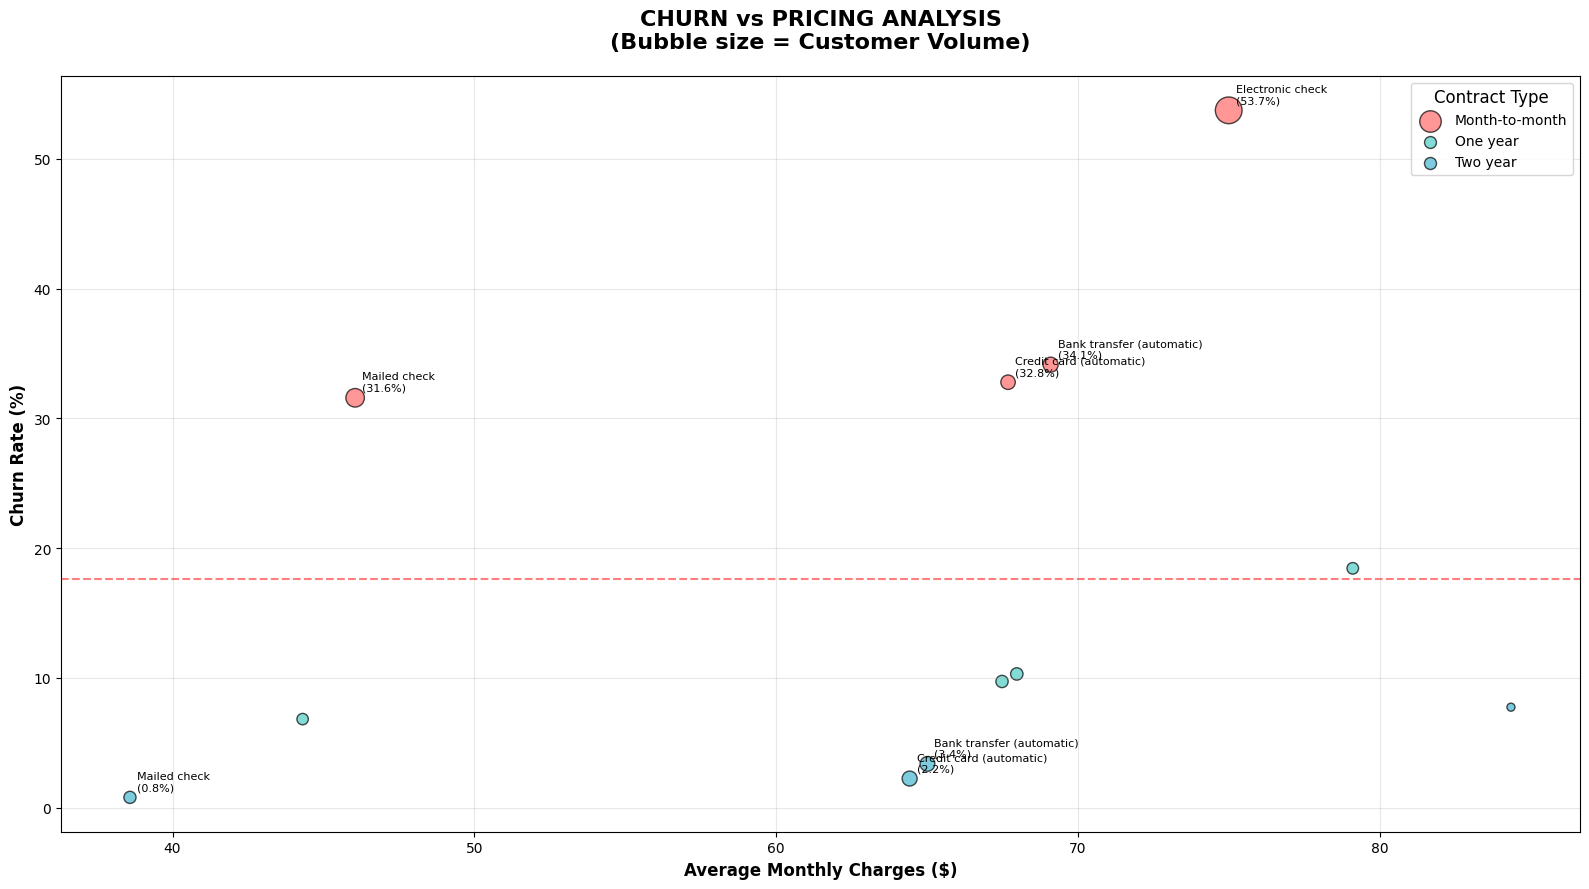

In [396]:
create_bubble_chart(churn_summary)

In [397]:
df = churn.get_churn_analysis_data()

# EDA Exploracion inicial
---

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7043 non-null   object 
 1   SeniorCitizen        7043 non-null   int64  
 2   Partner              7043 non-null   object 
 3   Dependents           7043 non-null   object 
 4   tenure               7043 non-null   int64  
 5   PhoneService         7043 non-null   object 
 6   MultipleLines        7043 non-null   object 
 7   InternetService      7043 non-null   object 
 8   OnlineSecurity       7043 non-null   object 
 9   OnlineBackup         7043 non-null   object 
 10  DeviceProtection     7043 non-null   object 
 11  TechSupport          7043 non-null   object 
 12  StreamingTV          7043 non-null   object 
 13  StreamingMovies      7043 non-null   object 
 14  Contract             7043 non-null   object 
 15  PaperlessBilling     7043 non-null   o

In [399]:
df.duplicated().any()

np.True_

In [400]:
df.isnull().sum()

gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
customer_segment       0
price_segment          0
additional_services    0
dtype: int64

In [401]:
for col in df.columns:
    print(f"Column: {col}")
    print(f"Num unique: {df[col].nunique()}")
    print("Unique values:", df[col].unique())
    print("-" * 40)



Column: gender
Num unique: 2
Unique values: ['Female' 'Male']
----------------------------------------
Column: SeniorCitizen
Num unique: 2
Unique values: [0 1]
----------------------------------------
Column: Partner
Num unique: 2
Unique values: ['Yes' 'No']
----------------------------------------
Column: Dependents
Num unique: 2
Unique values: ['No' 'Yes']
----------------------------------------
Column: tenure
Num unique: 73
Unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
----------------------------------------
Column: PhoneService
Num unique: 2
Unique values: ['No' 'Yes']
----------------------------------------
Column: MultipleLines
Num unique: 3
Unique values: ['No phone service' 'No' 'Yes']
----------------------------------------
Column: InternetService
Num unique: 3
Unique values: ['DSL' 

In [402]:
# Validar que no tenga columna con un valor unico
for col in df.columns:
    if len(df[col].unique())==1:
        print(f"{col}has only one unique value:{df[col].unique()}")

In [403]:

mask_empty_all = df.applymap(lambda x: isinstance(x, str) and x.strip() == '')

# Count of empty strings per column
empty_count_per_col = mask_empty_all.sum()

print("Number of empty strings per column:")
print(empty_count_per_col[empty_count_per_col != 0])

Number of empty strings per column:
TotalCharges    11
dtype: int64


In [404]:
df[df["TotalCharges"] == ""]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,customer_segment,price_segment,additional_services
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,New,Medium,4
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,New,Low,0
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,New,High,5
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,New,Low,0
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,New,Medium,5
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,New,Low,0
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,New,Low,0
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,New,Low,0
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,New,Low,0
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,New,High,4


### Insights de la data source: 
- 7_043 rows , 21 cols originales, agregadas algunas carcateristicas que pueden ayudar a dar algunas caracteristicas mas consistentes que otros.
- Se debe cambiar algunos datos, ajustandolos de object a float
- No hay data sucia necesariamente pero hay algunos datos en `()` y algunos con valores '' en TotalCharges
- No hay data duplicada


---

In [405]:
df["PaymentMethod"] = df.PaymentMethod.str.replace(" (automatic)","")
df.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

In [406]:
def ratio_check(serie_column: pd.Series, tope_value:float = 0.5) -> bool:

    ratio = serie_column.isna().sum() / serie_column.count()
    if ratio <= tope_value:

        transform_ratio_perc = ratio * 100.00
        print(f"El ratio: {transform_ratio_perc:.4f}, si es menor a 10% se puede imputar, si es mayor a 40% se puede retirar la columna")
    else:
        print("Cumple con caracteristicas ratio minimo")

In [407]:
#limpieza de la variable TotalCharges

df["TotalCharges"]= df["TotalCharges"].replace(" ",np.nan).replace("", np.nan)
#Convertir a valor flotante
df["TotalCharges"]= df["TotalCharges"].astype(float)
#Fill NaN con la median, pues el ratio de na/total_amount es minimo

ratio_check(df["TotalCharges"])

df["TotalCharges"]= df["TotalCharges"].fillna(df["TotalCharges"].median())


El ratio: 0.1564, si es menor a 10% se puede imputar, si es mayor a 40% se puede retirar la columna


## Analisis UniVariado

**Variable Target -> Churn**

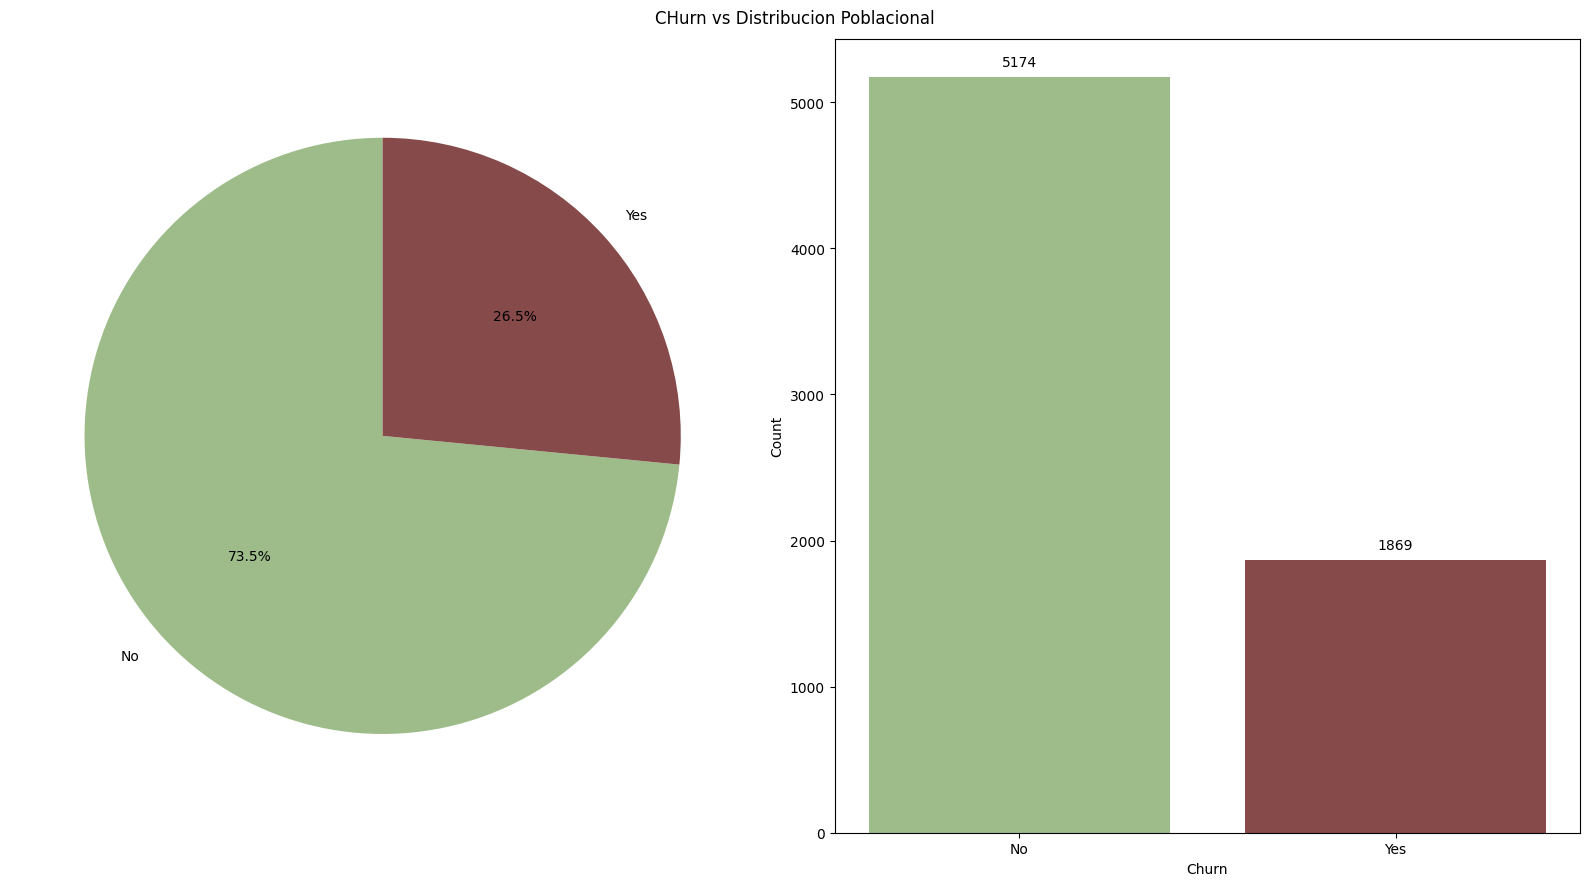

In [ ]:
## Distribucion del Dato Churn
churn_counts = df['Churn'].value_counts()

# Colors mapping
colors = {'Yes': '#874A4A', 'No': '#9EBC8A'}

# Create subplot (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 9)) 1]

# Pie chart 
axes[0].pie(
    churn_counts,
    labels=churn_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[colors[label] for label in churn_counts.index]
)

# axes[0].set_title('Distribucion de clase de Churn', fontsize=14)

# Bar chart 
bars = axes[1].bar(
    churn_counts.index,
    churn_counts.values,
    color=[colors[label] for label in churn_counts.index]
)

# Add numeric labels on top of bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2, 
        height + (0.01 * max(churn_counts.values)),  # a bit above the bar
        f'{int(height)}', 
        ha='center', va='bottom', fontsize=10
    )

# axes[1].set_title('Distribucion de clase de Churn', fontsize=14)
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Churn')

# Adjust layout
fig.suptitle("CHurn vs Distribucion Poblacional")
plt.tight_layout()
plt.show()



*Claramente observamos un desbalance de la cantidad de datos en la variable predictoria*

---

- *Analizar la relacion de las variables del tipo categoria vs target, para entender como influye cada una de las caracteristicas sobre el modelo.*
- *Las variables numericas y sus tendencias nos data mayor inferencia en como se correlacionan respecto a la variable target*
- *Tambien recordar como afecta la colinealidad y la multicolinealidad con la performance del analisis y de la respuesta en el modelo*

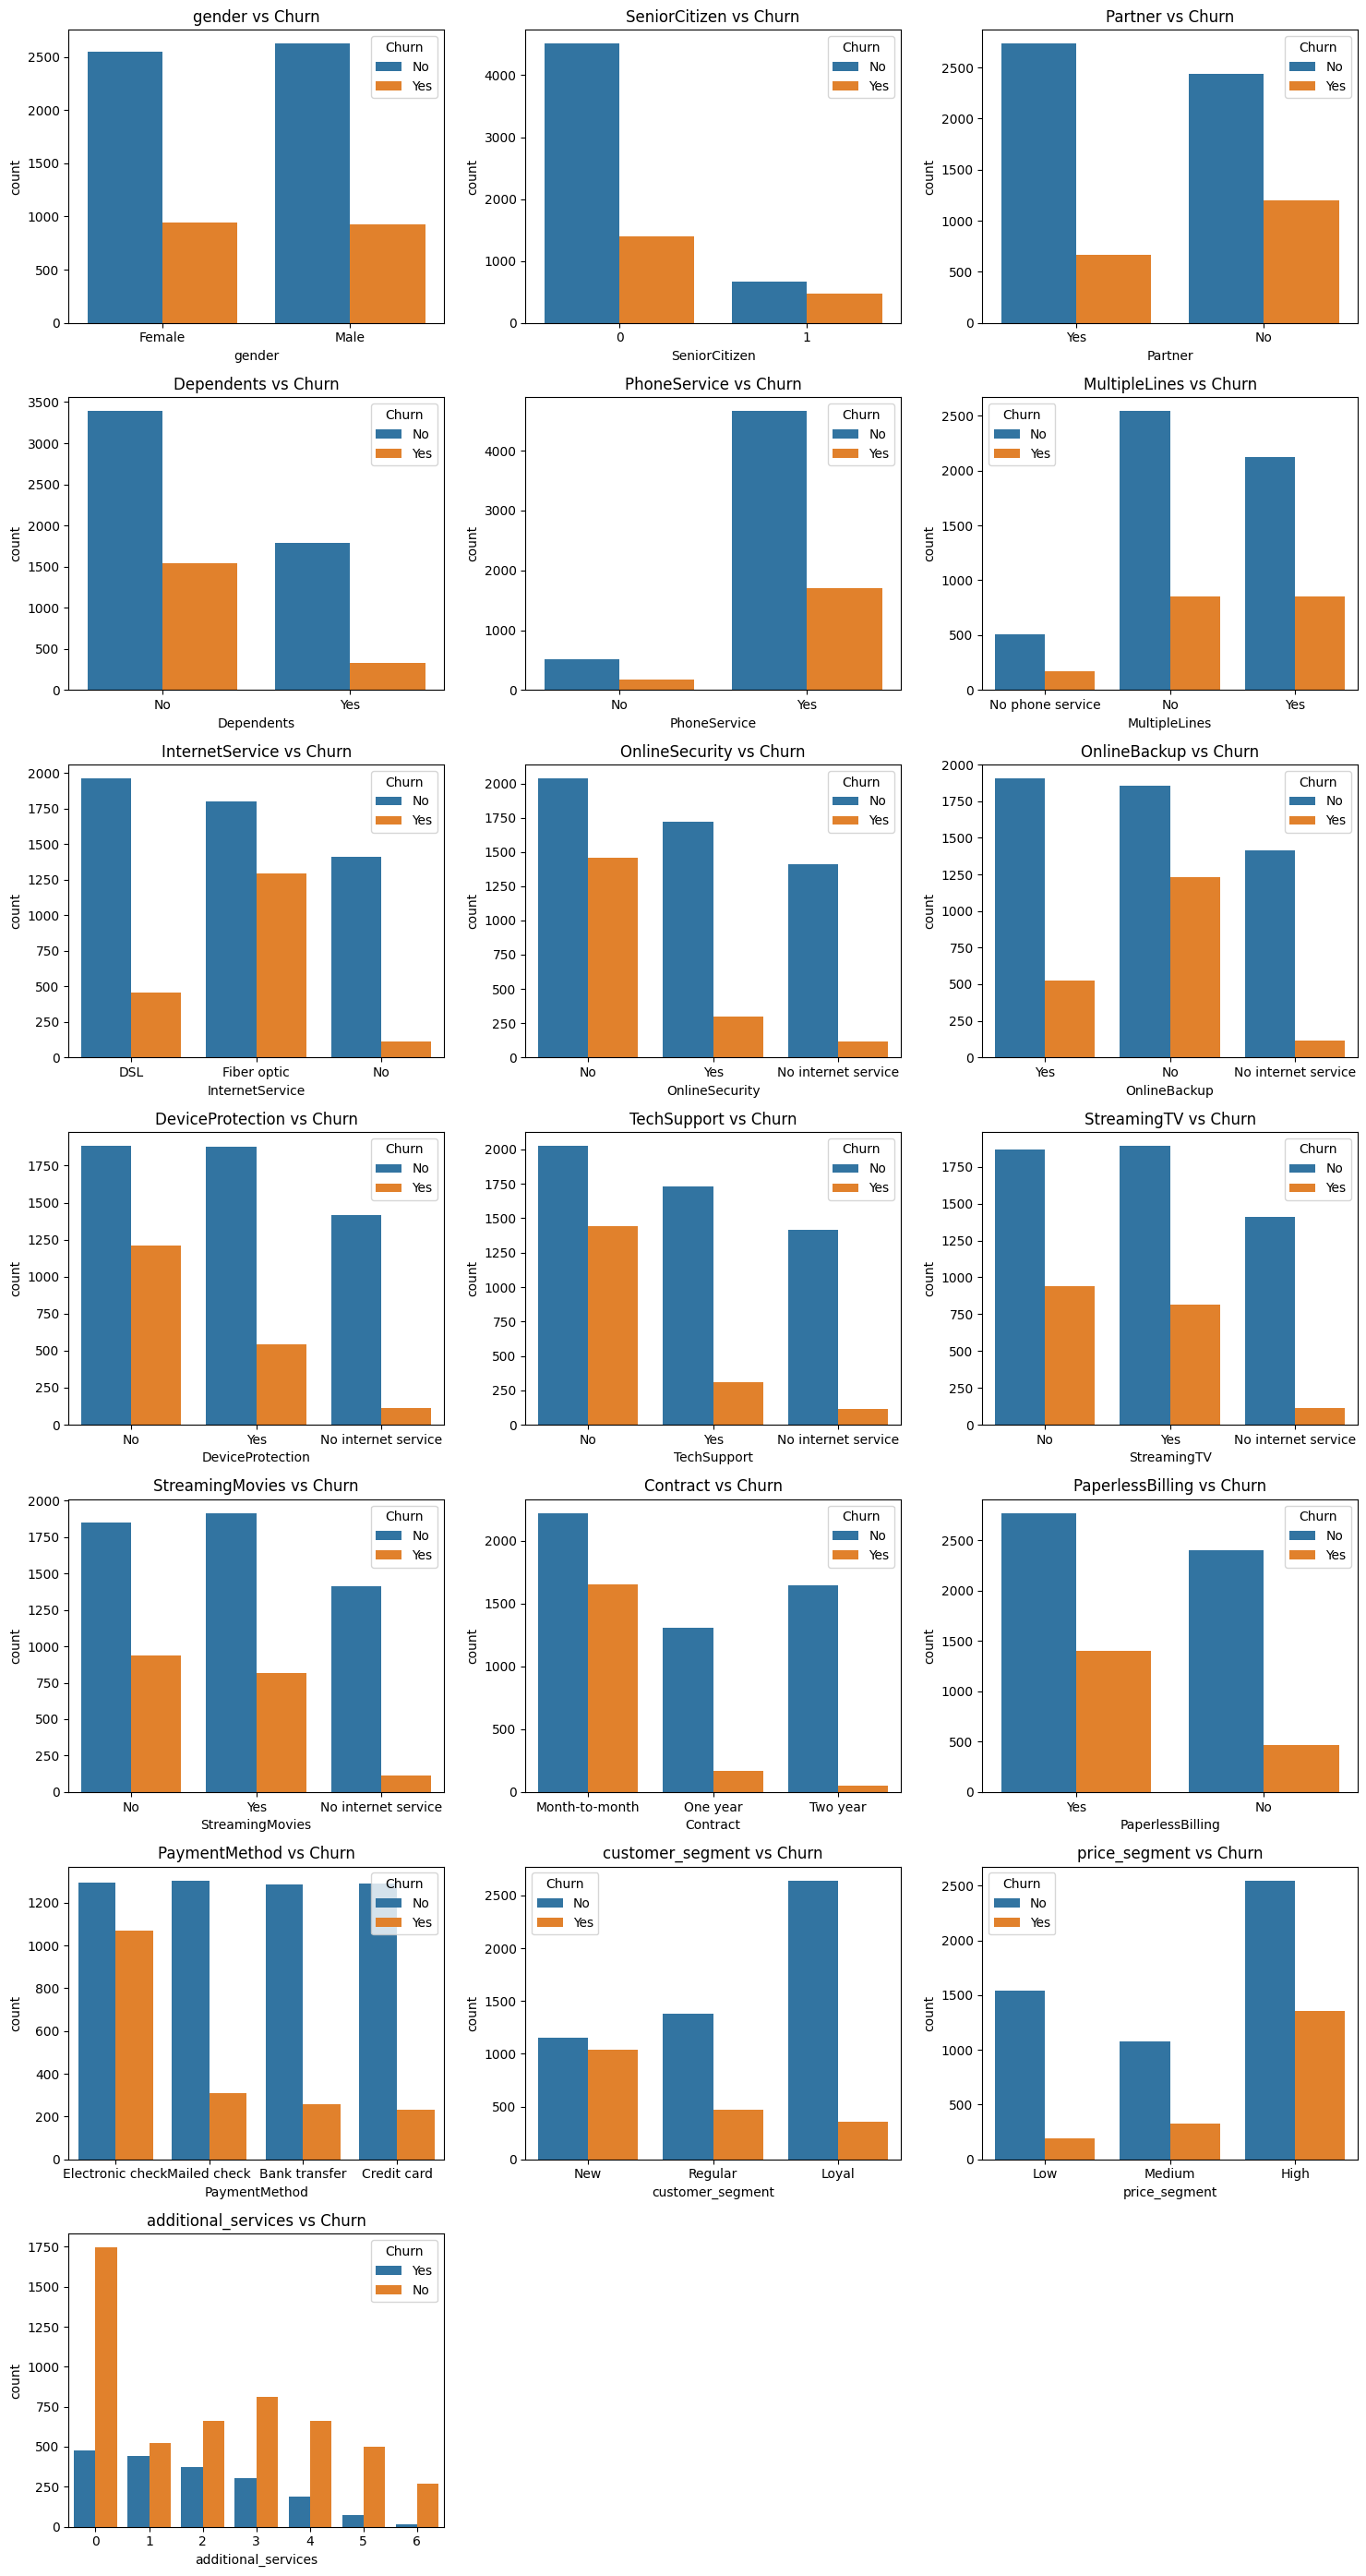

In [411]:
import math

cat_cols = [col for col in df.columns if df[col].nunique() <= 10 and col != "Churn"]

n_cols = 3  # 3 graphics by row
n_rows = math.ceil(len(cat_cols) / n_cols)

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()  

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue="Churn", data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs Churn")

for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

In [412]:
def pie_chart(df, columns, autopct='%1.1f%%'):
    # Define custom palette
    custom_palette = ['#73946B', '#9EBC8A', '#DDEB9D', '#F8ED8C', '#F9C784', '#FCAF58', '#F98948']
    
    num_cols = 3  # number of charts per row
    num_rows = int(np.ceil(len(columns) / num_cols))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        value_counts = df[column].value_counts()
        
        # Repeat colors if number of categories exceeds palette length
        colors = (custom_palette * ((len(value_counts) // len(custom_palette)) + 1))[:len(value_counts)]
        
        axes[i].pie(
            value_counts,
            labels=value_counts.index,
            autopct=autopct,
            startangle=90,
            colors=colors
        )
        axes[i].set_title(f"Distribution of {column}", fontsize=12)
        axes[i].axis('equal')
    
    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

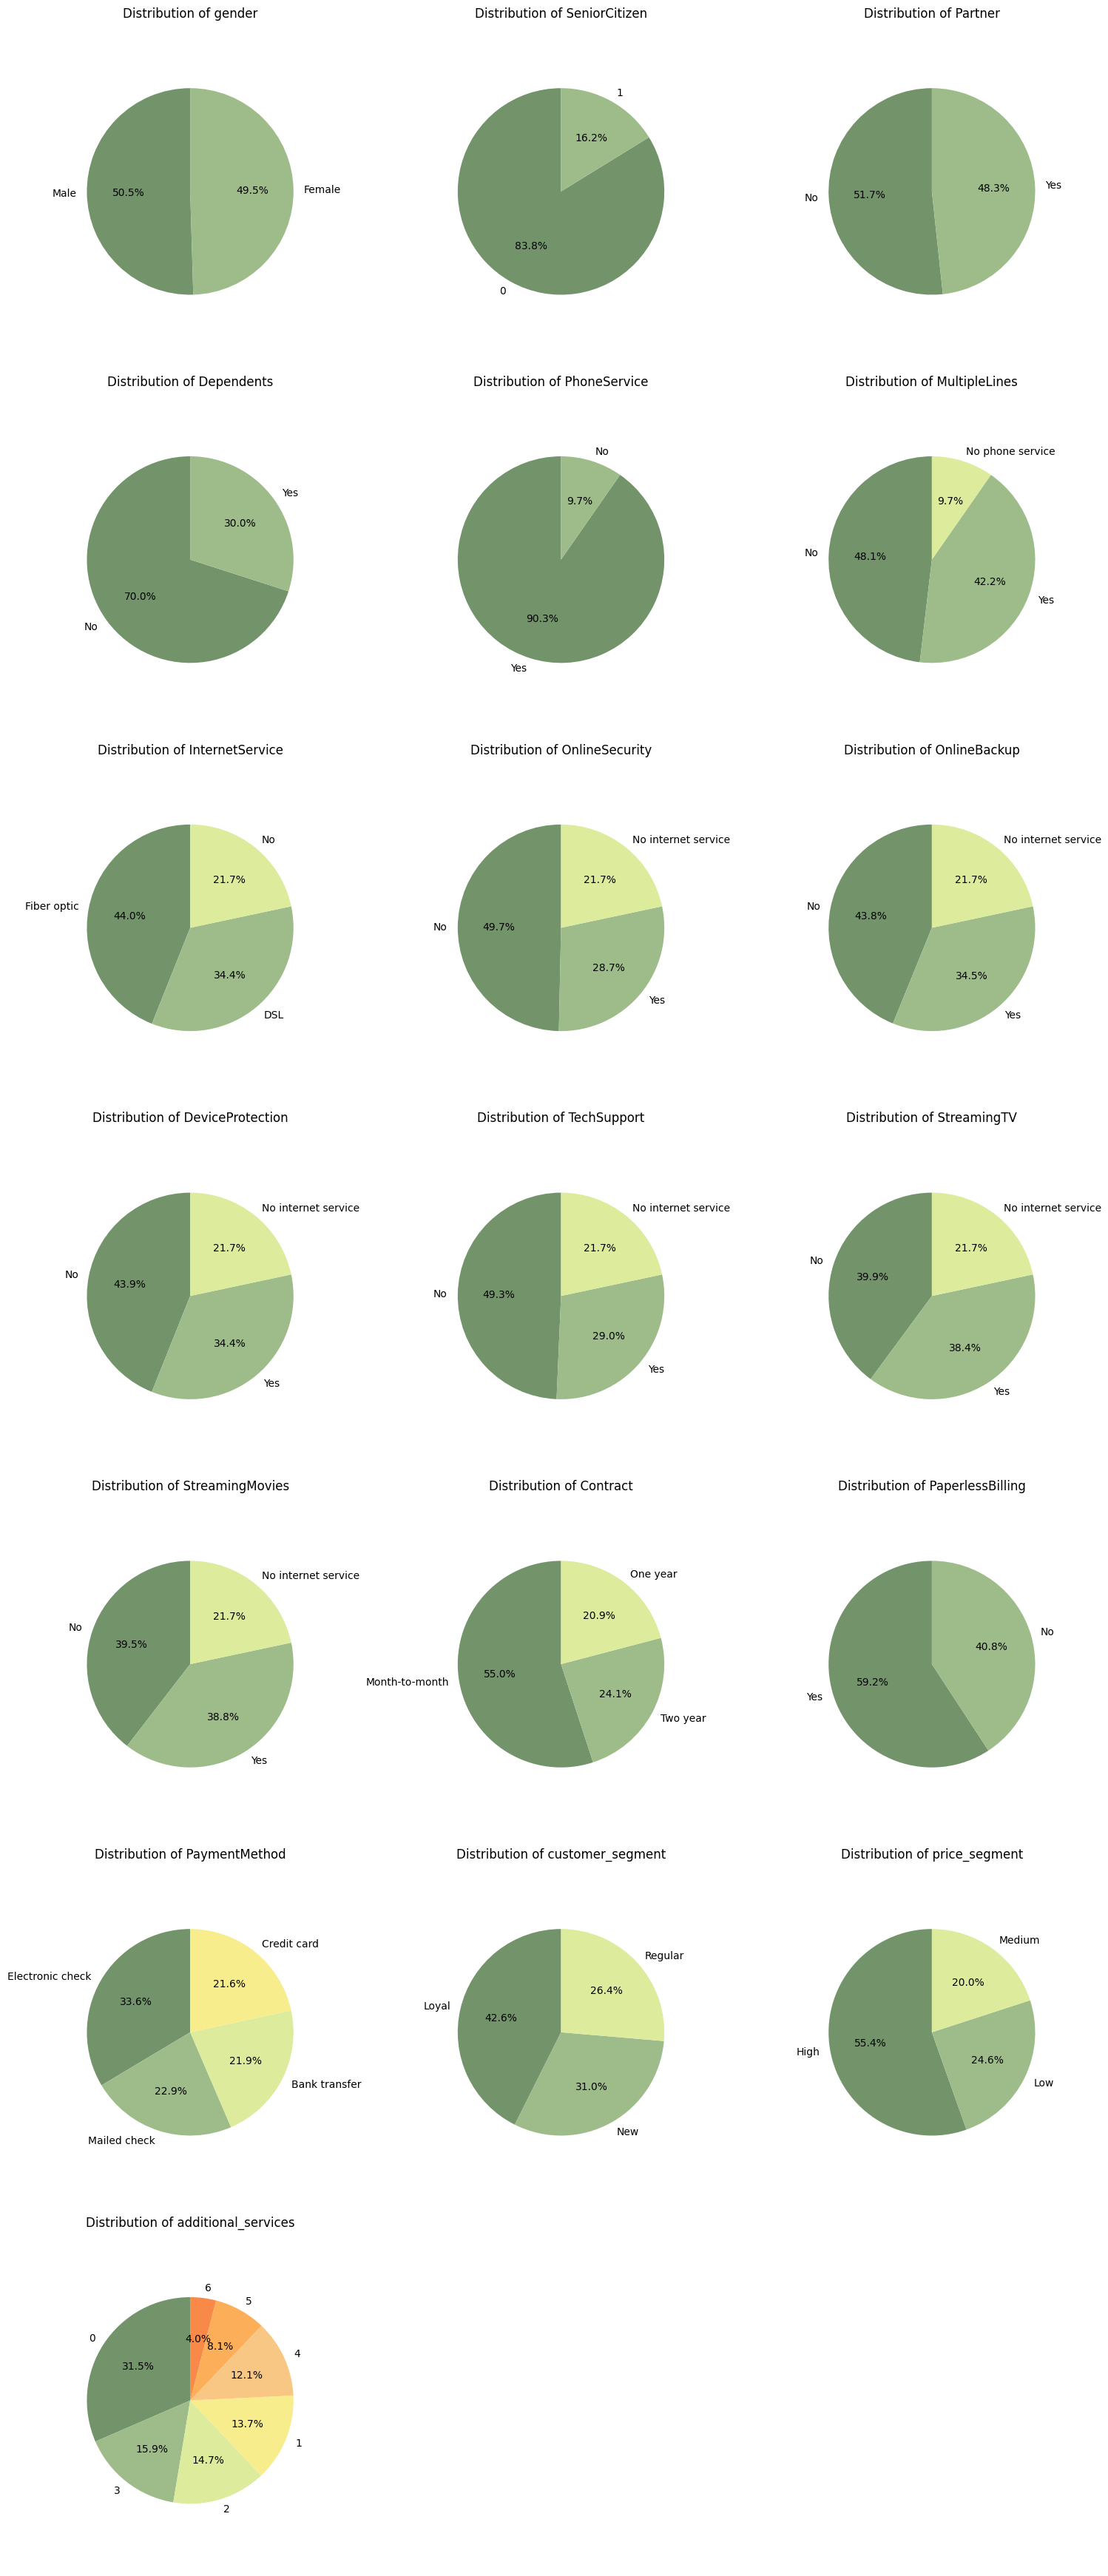

In [413]:
# Detalle de coqueteria que me parecio super interesante: (me gusta mucho mas esta opcion por ser de pocas variables)
pie_chart(df=df, columns=cat_cols)

Que es lo que podemos observar en base a lo que nos otorgan estos graficos?

-   Contract Type -> Hay una gran relacion con el churn, por lo tanto los clientes con un contrato del tipo `month-to-month` tienen un rate de churn mucho mas alto a comparacion del resto.
-   Payment method: Los que tienen pagos via electronic tienden a tener un churn mayor comparandolo con el resto
-   Internet Service - (Such as OnlineSecurity, TechSupport, and DeviceProtection) , tienen una correlacion con el churn, los que tienen esos servicios tienen esa tendencia al churn.
-   PaperlessBilling -> Posiblemente correlacionado por el metodo de pago que realiza al ser pago online
Observando lo demas podemos incidir que el resto de variables no tienen mucho peso en el comportamiento del cliente, tomando un papel secundario en la inferencia de las predicciones.


---
## Analisis biVariado

In [416]:
cat_cols_bivariate = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                      'Contract', 'PaperlessBilling', 'PaymentMethod']

def barchart_stacked(df, features, feature1='Churn'):
    colors = {'Yes': '#ce5454', 'No': '#9EBC8A'}

    ncols = 2
    nrows = int(np.ceil(len(features) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5*nrows))
    axes = axes.flatten()

    for i, feature2 in enumerate(features):
        ax = axes[i]

        # Prepare stacked data
        data = df.groupby([feature2, feature1]).size().reset_index(name='count')
        pivot_data = data.pivot(index=feature2, columns=feature1, values='count').fillna(0)

        # Plot stacked bars
        bottom_vals = np.zeros(len(pivot_data))
        for churn_status in colors.keys():
            ax.bar(
                pivot_data.index,
                pivot_data[churn_status],
                bottom=bottom_vals,
                color=colors[churn_status],
                label=churn_status
            )
            # Add number inside each segment
            for idx, val in enumerate(pivot_data[churn_status]):
                if val > 0:
                    ax.text(
                        idx, 
                        bottom_vals[idx] + val/2,
                        f"{int(val)}",
                        ha='center', va='center',
                        color='white', fontsize=10
                    )
            bottom_vals += pivot_data[churn_status]

        # Add total number on top
        for idx, total in enumerate(bottom_vals):
            ax.text(
                idx,
                total + (max(bottom_vals) * 0.02),
                f"{int(total)}",
                ha='center', va='bottom',
                fontsize=10
            )

        ax.set_title(f'{feature2} vs {feature1}')
        ax.set_xlabel(feature2)
        ax.set_ylabel('Number of Customers')
        ax.set_ylim(0, max(bottom_vals) * 1.15)

        # Rotate x-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

        # Move legend outside plot
        ax.legend(title=feature1, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Remove empty axes
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

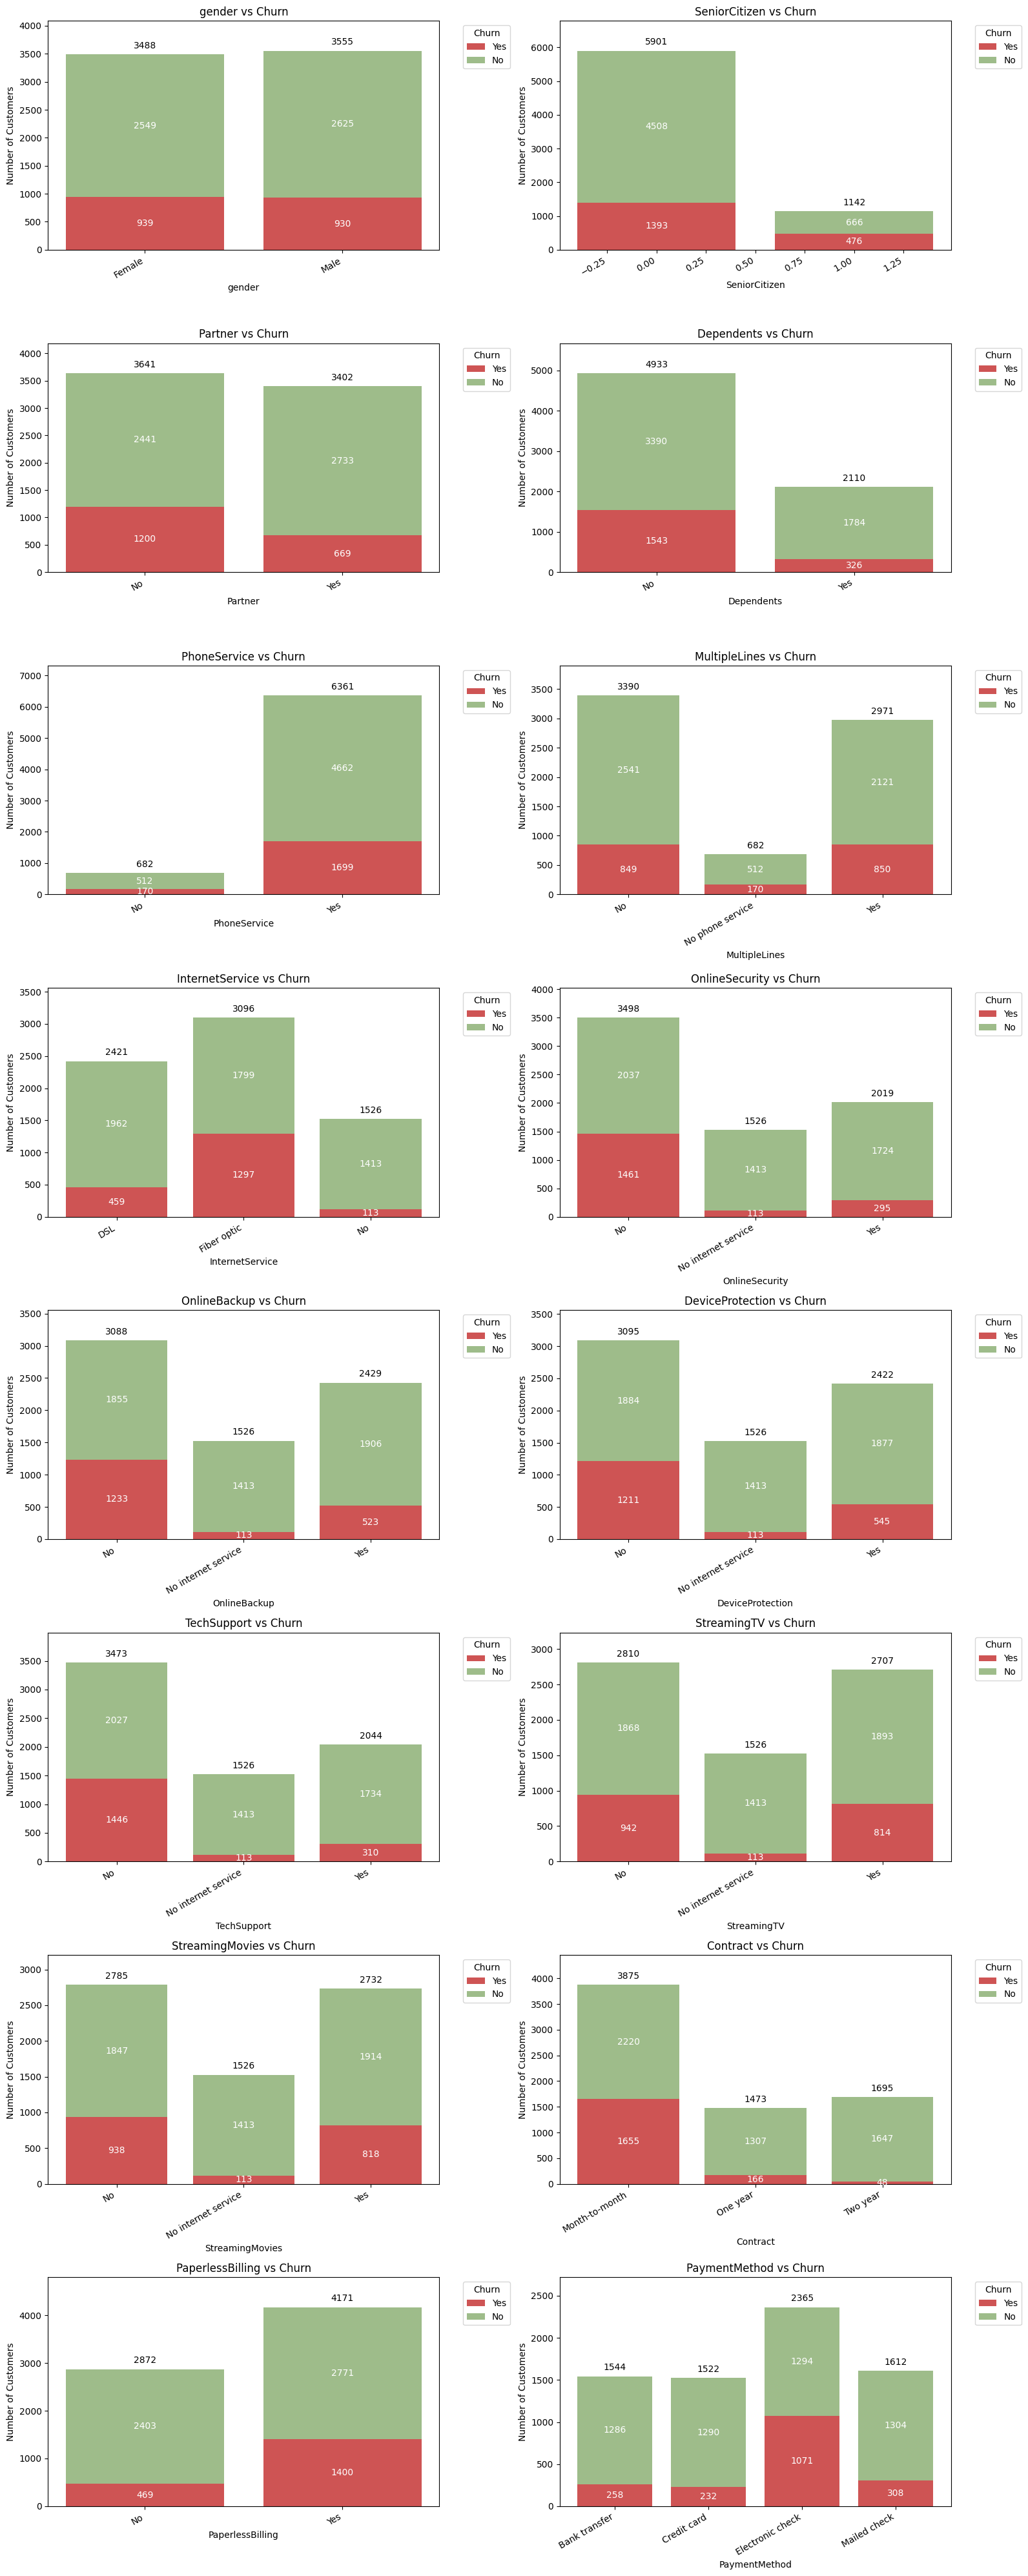

In [417]:
barchart_stacked(df, cat_cols_bivariate)

In [420]:
def barchart_bivariate(df, features, feature1='Churn'):
    colors = {'Yes': '#ce5454', 'No': '#9EBC8A'}
    
    ncols = 2
    nrows = int(np.ceil(len(features) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5*nrows))
    axes = axes.flatten()

    for i, feature2 in enumerate(features):
        ax = axes[i]
        
        # Calculate counts
        data = df.groupby([feature2, feature1]).size().reset_index(name='count')

        # Create barplot
        sns.barplot(
            data=data,
            x=feature2,
            y='count',
            hue=feature1,
            palette=colors,
            ax=ax
        )

        # Add numeric labels on top of bars
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(
                f"{int(height)}",
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom',
                xytext=(0, 6),  # distance from top of bar
                textcoords='offset points',
                color='black', fontsize=11
            )

        ax.set_title(f'{feature2} vs {feature1}')
        ax.set_xlabel(feature2)
        ax.set_ylabel('Number of Customers')
        ax.set_ylim(0, max(data['count']) * 1.15)

        # Rotate x-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

        # Move legend outside the plot
        ax.legend(title=feature1, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Remove empty axes if number of features is less than the grid slots
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

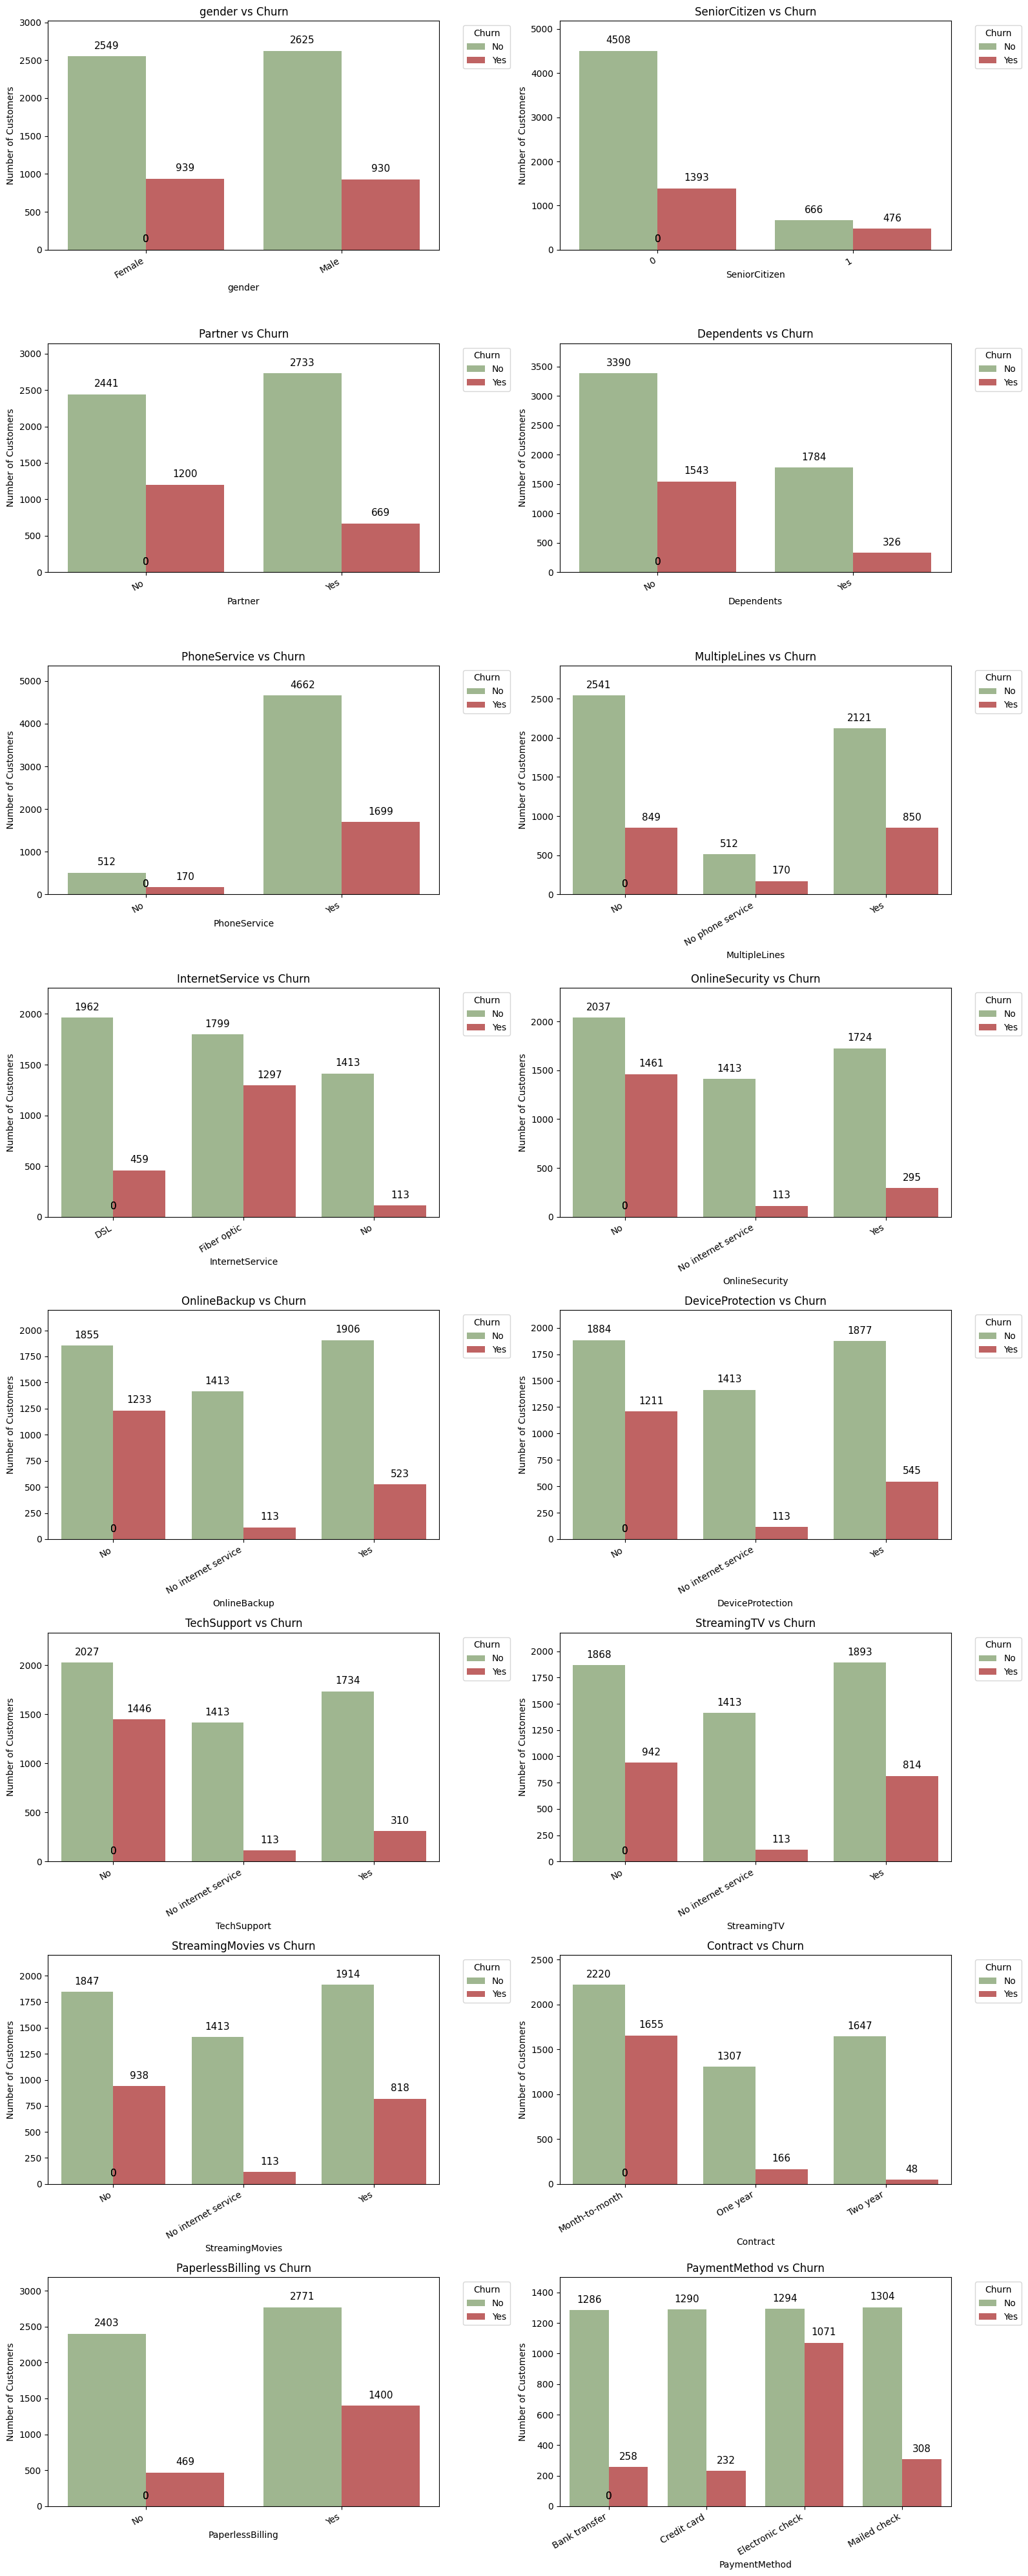

In [421]:
barchart_bivariate(df, cat_cols_bivariate)


Estos son los principales factores que influyen en la tasa de churn:

### Demografía del cliente

* **Género:** Los clientes masculinos y femeninos tienen tasas de deserción casi idénticas, por lo que el género no es un factor determinante. (dependiendo de la correlacion podriamos hasta removerlo de las caracteristicas dentro del modelo)

* **Tercera edad:** Los clientes de la tercera edad tienen una tasa de deserción más alta en comparación con los que no lo son. Esto puede deberse a la sensibilidad a los precios o a la necesidad de servicios especiales. -> Una variable bastante interesante.

* **Pareja y dependientes:** Los clientes que no tienen pareja ni dependientes son más propensos al churn, ya que suelen ser más "móviles" a la hora de cambiar de servicio. -> Muy buena variable

---

### Detalles del servicio

* **Servicio de internet:** Los clientes con servicio de **fibra óptica** tienen la mayor tasa de deserción, seguidos por los de **DSL**. Los clientes que no tienen servicio de internet presentan la tasa más baja. Esto probablemente esté influenciado por las expectativas de precio y rendimiento.

* **Servicios adicionales:** La falta de servicios adicionales (como seguridad en línea, respaldo, soporte técnico, etc.) se relaciona con una mayor deserción, lo que presenta una oportunidad para ventas adicionales.
* **Contrato:** Los contratos **mes a mes** tienen una tasa de deserción significativamente más alta que los contratos a 1 o 2 años. Los contratos a largo plazo son una manera efectiva de reducir la deserción.

---

### Facturación y pago
* **Facturación sin papel:** Los clientes que optan por la facturación sin papel tienen una tasa de deserción más alta, lo que a menudo está relacionado con contratos flexibles mes a mes.
* **Método de pago:** Los clientes que pagan con **cheque electrónico** presentan la tasa de deserción más alta. Los pagos por transferencia bancaria, tarjeta de crédito y cheque por correo tienen una tasa de deserción más baja. El cheque electrónico es un método de pago común entre los clientes de alto riesgo.

In [424]:
def displot(df, features, feature1='Churn'):
    n_features = len(features)
    ncols = 1
    nrows = (n_features + 1) // 1
    
    plt.figure(figsize=(16, 5*nrows))
    
    # Warna untuk kelas churn
    palette = {
        'Yes': '#ce5454',    # Not Churn
        'No' : '#9EBC8A'    # Churn
    }
    
    for i, feature2 in enumerate(features, 1):
        plt.subplot(nrows, ncols, i)
        
        for cls in df[feature1].unique():
            subset = df[df[feature1] == cls]
            sns.kdeplot(subset[feature2], 
                        shade=True, 
                        alpha=0.5, 
                        color=palette[cls], 
                        label='Churn' if cls == 'Yes' else 'Not Churn')
        
        plt.title(f'{feature2} vs {feature1}')
        plt.xlabel(feature2)
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


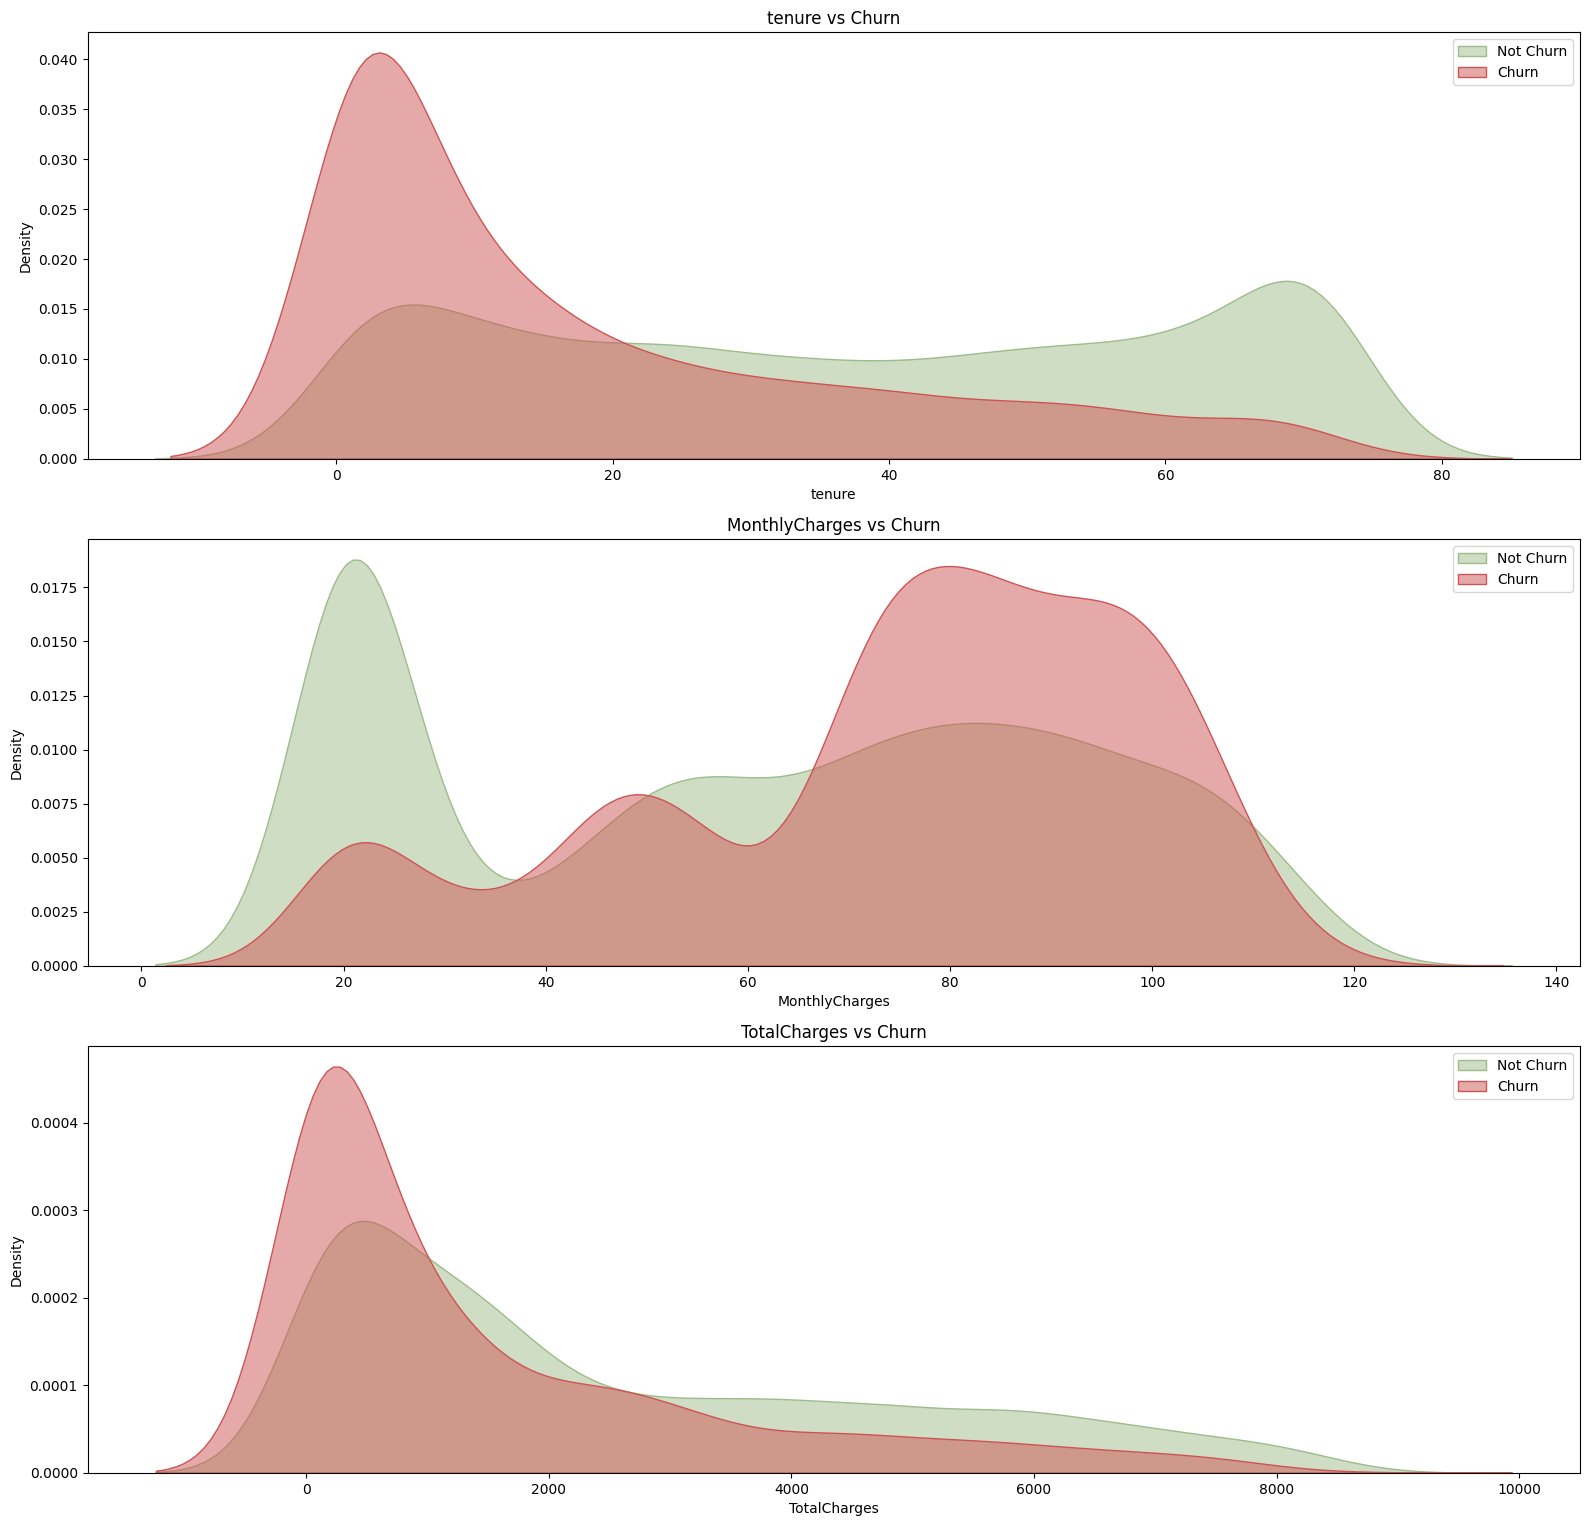

In [425]:
displot(df, num_cols:= ['tenure', 'MonthlyCharges', 'TotalCharges'])

### Perfil de los clientes con alta deserción
* **Contrato y facturación:** Los clientes con contrato **mes a mes** y que usan **facturación sin papel** tienen un riesgo de deserción mucho mayor. Esto a menudo se relaciona con la flexibilidad de su servicio.

* **Servicio de internet:** La **fibra óptica** tiene la tasa de deserción más alta, seguida por **DSL**. La falta de servicios adicionales (como seguridad en línea, respaldo, o soporte técnico) también está asociada con una mayor deserción.

* **Demografía y pagos:** Los clientes **sin pareja ni dependientes** y los **adultos mayores** son más propensos a desertar. El pago con **cheque electrónico** es el método con la tasa de deserción más alta.

* **Cargos mensuales:** Existe un pico de deserción en el rango de $70 a $100 en cargos mensuales, lo que sugiere una sensibilidad al precio en este segmento.

---

### Estrategias de retención
* **Enfoque en clientes nuevos:** La mayoría de los clientes que se van tienen una baja antigüedad y cargos totales bajos. Es crucial enfocar los esfuerzos de retención en la experiencia inicial del cliente, especialmente durante los **primeros meses**.

* **Fidelización:** Los clientes con mayor antigüedad y cargos totales son mucho menos propensos a irse. La tasa de deserción es muy baja después de 20 meses.

* **Oportunidades:** Se recomienda apuntar a los clientes nuevos y a aquellos con facturas altas, ofreciéndoles promociones, un mejor proceso de incorporación y servicios de valor agregado para reducir la deserción.

* **Contratos a largo plazo:** Fomentar contratos a 1 o 2 años es una manera efectiva de reducir la deserción, ya que los contratos a largo plazo demuestran ser un factor clave de retención.

## Correlacion con HEATMAP

In [435]:
def create_churn_focused_heatmap(df_encoded, target_variable='Churn'):
    """Heatmap enfocado en correlaciones con la variable de churn"""
    
    # Calcular correlación
    corr_matrix = df_encoded.corr()
    
    # Obtener correlaciones con la variable target
    if target_variable in corr_matrix.columns:
        target_correlations = corr_matrix[target_variable].abs().sort_values(ascending=False)
        
        # Seleccionar top variables más correlacionadas con churn
        top_variables = target_correlations.head(15).index.tolist()
        
        # Crear submatriz con las variables más relevantes
        corr_subset = corr_matrix.loc[top_variables, top_variables]
    else:
        corr_subset = corr_matrix
    
    # Crear heatmap
    fig = go.Figure(data=go.Heatmap(
        z=corr_subset.values,
        x=corr_subset.columns,
        y=corr_subset.index,
        colorscale='RdBu_r',  # Rojo-Azul invertido
        zmid=0,
        text=np.round(corr_subset.values, 3),
        texttemplate="%{text}",
        textfont={"size": 10},
        colorbar=dict(
            title="Correlation with<br>Churn Variable",
            # titlefont=dict(size=12)
        )
    ))
    
    # Destacar la fila/columna del target
    if target_variable in corr_subset.columns:
        target_idx = corr_subset.columns.get_loc(target_variable)
        
        # Añadir líneas para destacar la variable target
        fig.add_hline(y=target_idx, line_width=3, line_color="red", opacity=0.7)
        fig.add_vline(x=target_idx, line_width=3, line_color="red", opacity=0.7)
    
    fig.update_layout(
        title={
            'text': f'🎯 Churn-Focused Correlation Analysis<br><sub>Top variables correlated with {target_variable}</sub>',
            'x': 0.5,
            'font': {'size': 18}
        },
        width=900,
        height=700,
        xaxis=dict(tickangle=45),
        yaxis=dict(autorange='reversed')
    )
    
    fig.show()
    
    # Mostrar ranking de correlaciones con churn
    if target_variable in df_encoded.columns:
        churn_corr = df_encoded.corr()[target_variable].abs().sort_values(ascending=False)
        print(f"\n🔍 Top 15 variables correlated with {target_variable}:")
        print("=" * 50)
        for var, corr in churn_corr.head(15).items():
            if var != target_variable:
                print(f"{var:<25}: {corr:.3f}")

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler

# --- Columnas ---
bin_cols = ["gender","Partner","Dependents","PhoneService","PaperlessBilling"]abs

ordinal_cols = ["customer_segment", "price_segment", "additional_services"] # segmentaciones por agregado

num_cols = ["tenure", "SeniorCitizen", "MonthlyCharges", "TotalCharges"]

multi_cols_for_dummies = [
    "MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies",
    "Contract","PaymentMethod"
]

# --- Mapas y categorías ---
mapper_columns_bins = {"Yes":1, "No":0, "Male":1, "Female":0}

ordinal_categories = [
    ["New", "Regular", "Loyal"],   # customer_segment
    ["Low", "Medium", "High"],     # price_segment
    [0, 1, 2, 3, 4, 5, 6]          # additional_services
]


# --- Transformadores ---

# --- Función para mapear binarias ---

def map_bins(X):
    return X.applymap(lambda x: mapper_columns_bins.get(x, x))

bin_transformer = FunctionTransformer(func=map_bins, validate=False)

ordinal_transformer = OrdinalEncoder(categories=ordinal_categories)

multi_transformer = OneHotEncoder(handle_unknown="error")

scaling = StandardScaler()


# --- ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ("bin", bin_transformer, bin_cols),
        ("ord", ordinal_transformer, ordinal_cols),
        ("multi", multi_transformer, multi_cols_for_dummies),
        ("scale", scaling, num_cols)  # ahora escalás tenure, SeniorCitizen, MonthlyCharges, TotalCharges
    ],
    remainder="passthrough"
)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor)
])


### Datos completamente numericos para analisis del tipo de correlacion

In [427]:
df_trans = pipe.fit_transform(df)
df_trans

array([[0, 1, 0, ..., -1.1603229160349193, -0.9942419353101233, 'No'],
       [1, 0, 0, ..., -0.2596289419448806, -0.17324412574959375, 'No'],
       [1, 0, 0, ..., -0.3626603559551803, -0.9596740712020441, 'Yes'],
       ...,
       [0, 1, 1, ..., -1.16863190103575, -0.8544694477415681, 'No'],
       [1, 1, 0, ..., 0.32033821111309646, -0.8720624156177744, 'Yes'],
       [1, 0, 0, ..., 1.3589613362169235, 2.014288015444945, 'No']],
      shape=(7043, 44), dtype=object)

In [428]:
# Accedemos al preprocessor entrenado
preprocessor_fitted = pipe.named_steps["preprocessor"]

# --- Columnas binarias (los nombres originales sirven)
bin_features = bin_cols

# --- Columnas ordinales (OrdinalEncoder NO soporta get_feature_names_out, devolvemos original)
ord_features = ordinal_cols

# --- Columnas one-hot (sí soporta)
multi_features = preprocessor_fitted.named_transformers_["multi"].get_feature_names_out(multi_cols_for_dummies)

# --- Columnas escaladas (StandardScaler tampoco soporta nombres automáticos)
scaling_features = num_cols

# --- Columnas remainder
remainder_features = [
    col for col in df.columns
    if col not in bin_cols + ordinal_cols + multi_cols_for_dummies + num_cols
]


print(remainder_features)
# --- Concatenamos todos los nombres
all_features = np.concatenate([
    bin_features,
    ord_features,
    multi_features,
    scaling_features,
    remainder_features
])

# --- Reconstruimos DataFrame
df_trans = pd.DataFrame(
    df_trans.toarray() if hasattr(df_trans, "toarray") else df_trans,
    columns=all_features
)


df_trans["Churn"] = df_trans["Churn"].map({"Yes":1,"No":0})

print(df_trans.shape)

print(df_trans.info())
df_trans.head()


['SeniorCitizen', 'Churn']
(7043, 44)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   gender                                7043 non-null   object
 1   Partner                               7043 non-null   object
 2   Dependents                            7043 non-null   object
 3   PhoneService                          7043 non-null   object
 4   PaperlessBilling                      7043 non-null   object
 5   customer_segment                      7043 non-null   object
 6   price_segment                         7043 non-null   object
 7   additional_services                   7043 non-null   object
 8   MultipleLines_No                      7043 non-null   object
 9   MultipleLines_No phone service        7043 non-null   object
 10  MultipleLines_Yes                     7043 non-null   obje

,gender,Partner,Dependents,PhoneService,PaperlessBilling,customer_segment,price_segment,additional_services,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Churn
0,0,1,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.277445,-0.439916,-1.160323,-0.994242,0
1,1,0,0,1,0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.066327,-0.439916,-0.259629,-0.173244,0
2,1,0,0,1,1,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.236724,-0.439916,-0.36266,-0.959674,1
3,1,0,0,0,0,2.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.514251,-0.439916,-0.746535,-0.194766,0
4,0,0,0,1,1,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.236724,-0.439916,0.197365,-0.94047,1


In [429]:
# Convertir todas las columnas a float
df_trans = df_trans.apply(pd.to_numeric, errors='coerce')

In [431]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   gender                                7043 non-null   int64  
 1   Partner                               7043 non-null   int64  
 2   Dependents                            7043 non-null   int64  
 3   PhoneService                          7043 non-null   int64  
 4   PaperlessBilling                      7043 non-null   int64  
 5   customer_segment                      7043 non-null   float64
 6   price_segment                         7043 non-null   float64
 7   additional_services                   7043 non-null   float64
 8   MultipleLines_No                      7043 non-null   float64
 9   MultipleLines_No phone service        7043 non-null   float64
 10  MultipleLines_Yes                     7043 non-null   float64
 11  InternetService_D

In [430]:
df_trans.head()

,gender,Partner,Dependents,PhoneService,PaperlessBilling,customer_segment,price_segment,additional_services,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Churn
0,0,1,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.277445,-0.439916,-1.160323,-0.994242,0
1,1,0,0,1,0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.066327,-0.439916,-0.259629,-0.173244,0
2,1,0,0,1,1,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.236724,-0.439916,-0.362660,-0.959674,1
3,1,0,0,0,0,2.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.514251,-0.439916,-0.746535,-0.194766,0
4,0,0,0,1,1,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.236724,-0.439916,0.197365,-0.940470,1


In [436]:
create_churn_focused_heatmap(df_trans)


🔍 Top 15 variables correlated with Churn:
Contract_Month-to-month  : 0.405
tenure                   : 0.352
OnlineSecurity_No        : 0.343
customer_segment         : 0.339
TechSupport_No           : 0.337
InternetService_Fiber optic: 0.308
Contract_Two year        : 0.302
PaymentMethod_Electronic check: 0.302
OnlineBackup_No          : 0.268
DeviceProtection_No      : 0.252
DeviceProtection_No internet service: 0.228
StreamingMovies_No internet service: 0.228
OnlineBackup_No internet service: 0.228
OnlineSecurity_No internet service: 0.228


---

## MODELING AND PRE PROCESSING

*Dado a todo lo investigado y conocer las relaciones que se ejercen directamente las features del dataset, podriamos usar las variables que mejor se nos ajuste, sin embargo, para seguir el mismo concepto de Quick & Dirty, vamos a hacer uso*

Dividir los datos en **train / validation / test** para poder:

* entrenar el modelo (`train`),
* ajustar hiperparámetros (`validation`),
* y evaluar el desempeño final (`test`).


### Opciones

* Si solo necesitás **train/test**, basta con un solo `train_test_split`.
* Si vas a usar algo como **GridSearchCV o RandomizedSearchCV**, no necesitás `validation` explícito: esas clases ya hacen validación cruzada.
* Para problemas de **churn** (clasificación con clases desbalanceadas) recomiendo **usar `stratify=y`** para que la proporción de churn/no-churn se mantenga igual en los splits.



In [ ]:
from sklearn.model_selection import train_test_split
# Data split

# Supongamos que ya tenés X (features) y y (target)
X = df_trans.drop("Churn", axis=1)
y = df_trans["Churn"]

# Primero separamos train+val vs test (20% para test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  Luego de train+val, volvemos a separar: train (60%), val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)
# (0.25 de 0.8 = 0.20 → o sea: 60% train, 20% val, 20% test)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

print(X_train.columns)
X_train.info()


In [ ]:
X_train.head()

In [ ]:
print("Distribution before SMOTE:")
print(y_train.value_counts())

* `SMOTE` → genera nuevas muestras **sintéticas** para la clase minoritaria.
* `TomekLinks` → elimina ejemplos de la clase mayoritaria que están muy cerca de la minoritaria (ruido/solapamiento).
* `SMOTETomek` → combina ambos pasos en una sola estrategia.

In [ ]:
from imblearn.combine import SMOTETomek

# Aplicamos SMOTE + Tomek Links SOLO al set de entrenamiento
smt = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smt.fit_resample(X_train, y_train)

print("Antes del balanceo:", y_train.value_counts(normalize=True))
print("Después del balanceo:", y_train_bal.value_counts(normalize=True))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, roc_auc_score, average_precision_score
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

# Definimos folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definimos métricas

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": "roc_auc",   # AUC-ROC
    "pr_auc": make_scorer(average_precision_score, needs_proba=True)  # AUC-PR
}

# Modelos baseline
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced")
}


In [ ]:
set(bin_cols + ordinal_cols + multi_cols_for_dummies + num_cols) - set(X_train.columns)

In [ ]:
from joblib import Memory
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

memory = Memory(location="./mem_cached", verbose=0)

# --- Función para entrenar y devolver modelos ---
def train_models(models_dict, X, y, balance=True):
    trained_models = {}
    
    for name, model in models_dict.items():
        steps = []
        if balance:
            steps.append(("balance", SMOTETomek(random_state=42)))
        steps.append(("model", model))
        
        pipe = ImbPipeline(steps=steps, memory=memory)
        pipe.fit(X, y)
        
        trained_models[name] = pipe
    
    return trained_models


# --- Función para evaluar modelos entrenados ---
def evaluate_models(trained_models, X, y):
    results = {}
    
    for name, model in trained_models.items():
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:,1]
        
        results[name] = {
            "accuracy": accuracy_score(y, y_pred),
            "precision": precision_score(y, y_pred),
            "recall": recall_score(y, y_pred),
            "f1": f1_score(y, y_pred),
            "roc_auc": roc_auc_score(y, y_proba),
            "pr_auc": average_precision_score(y, y_proba)
        }
    
    results_df = pd.DataFrame(results).T
    return results_df


In [ ]:
# Entrenamos los modelos
trained_models = train_models(models, X_train, y_train)


In [ ]:

# Evaluamos en validación
results_val = evaluate_models(trained_models, X_val, y_val)
results_val

In [ ]:
# Evaluamos en test
results_test = evaluate_models(trained_models, X_test, y_test)
results_test

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- Matriz de confusión para un modelo específico ---
selected_model_name = "LightGBM"
selected_model = trained_models[selected_model_name]

y_pred = selected_model.predict(X_val)
y_proba = selected_model.predict_proba(X_val)[:,1]

cm = confusion_matrix(y_val, y_pred)
cm_text = [[f"{cm[i,j]}" for j in range(cm.shape[1])] for i in range(cm.shape[0])]

fig_cm = go.Figure(data=go.Heatmap(
    z=cm,neSecurity_No        : 0.343
customer_segment         : 0.339
TechSupport_No           : 0.337
InternetService_Fiber optic: 0.308
Contract_Two year        : 0.302
PaymentMethod_Electronic che
    x=["No Churn", "Churn"],
    y=["No Churn", "Churn"],
    text=cm_text,
    texttemplate="%{text}", 
    colorscale="Blues"
))
fig_cm.update_layout(title=f"Matriz de Confusión - {selected_model_name}")


# --- Curva ROC para todos los modelos ---
fig_roc = go.Figure()
for name, model in trained_models.items():
    y_val_proba = model.predict_proba(X_val)[:,1]
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)
    fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f"{name} (AUC={roc_auc:.3f})"))

fig_roc.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', line=dict(dash='dash'), name='Random'))
fig_roc.update_layout(title="Curva ROC - Modelos Comparados", 
                      xaxis_title="False Positive Rate", 
                      yaxis_title="True Positive Rate")

fig_cm.show()
fig_roc.show()
